In [35]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import time
import pandas as pd

In [36]:
print("Carregando dados")
data = np.loadtxt('./data/wine.data', delimiter=',')

X, y = data[:, 1:], data[:,0]

# Transforma em problema de classificacao binaria
idxs = [i for i in range(len(y)) if y[i] == 1 or y[i] == 2]
X, y = X[idxs], y[idxs]

# Normaliza os dados
X = (X - X.mean(axis=0))/(X.max(axis=0) - X.min(axis=0))
X = np.hstack((X, np.ones(len(X)).reshape(len(X),1)))

# Transforma variavel target
y = np.array(list(map(lambda x: 0 if x == 1 else 1, y)))

print(f"Dataset: {X.shape[0]} amostras, {X.shape[1]} features (13 + 1 bias)")

Carregando dados
Dataset: 130 amostras, 14 features (13 + 1 bias)


In [37]:
print("\nTreinando modelo benchmark (Scikit-Learn)")
reg = LogisticRegression(solver='sag', C=100000, max_iter=10000).fit(X, y)
L_star = log_loss(y, reg.predict_proba(X))
print(f"Loss L* (benchmark) = {L_star:.10f}")


Treinando modelo benchmark (Scikit-Learn)
Loss L* (benchmark) = 0.0003979725


In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def cross_entropy_loss(y, y_pred):
    epsilon = 1e-15  # Para evitar log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -(1/len(y))*np.sum(y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred))
    return loss

def cross_entropy_grad(y, y_pred, X):
    return list(np.dot((y_pred - y), X)[0])

def compute_loss_for_weights(w, X, y):
    """Calcula loss para um dado conjunto de pesos"""
    y_pred = sigmoid(np.dot(w.T, X.T))
    return cross_entropy_loss(y, y_pred)

In [39]:
print("\n" + "="*70)
print("DESCIDA COORDENADA COM GRADIENTE (14 PESOS)")
print("="*70)

w_gradient = np.zeros(14).reshape(14, 1)
eta = 0.01
num_features = 14

# Parâmetros de convergência
patience = 1000  # Número de iterações sem melhoria significativa
min_improvement = 1e-6  # Melhoria mínima considerada significativa
max_iter = 1000000  # Limite máximo de iterações

loss_gradient = []
weights_history_gradient = []
gradient_selections = np.zeros(num_features)
iteration_log = []  # Para tabela de evolução

best_loss = float('inf')
no_improvement_count = 0

print(f"\nParâmetros de convergência:")
print(f"  - Paciência: {patience} iterações")
print(f"  - Melhoria mínima: {min_improvement}")
print(f"  - Máximo de iterações: {max_iter}")

start_time = time.time()
pbar = tqdm(desc="Descida com Gradiente (14 pesos)", total=max_iter)

for t in range(max_iter):
    y_pred = sigmoid(np.dot(w_gradient.T, X.T))
    current_loss = cross_entropy_loss(y, y_pred)
    loss_gradient.append(current_loss)
    
    grad = cross_entropy_grad(y, y_pred, X)
    
    # Seleciona a coordenada com maior gradiente (em valor absoluto)
    grad_abs = [abs(g) for g in grad]
    best_index = grad_abs.index(max(grad_abs))
    gradient_selections[best_index] += 1
    
    # Atualiza apenas o peso com maior gradiente
    w_gradient[best_index] = w_gradient[best_index] - eta*grad[best_index]
    
    # Salva histórico
    weights_history_gradient.append(w_gradient.flatten().copy())
    
    # Log a cada 1000 iterações
    if t % 1000 == 0 or t < 10:
        iteration_log.append({
            'Iteração': t,
            'Loss': current_loss,
            'Melhor Índice': best_index,
            'Gradiente Max': max(grad_abs),
            'Delta Loss': current_loss - best_loss if t > 0 else 0
        })
    
    # Verifica convergência
    if current_loss < best_loss - min_improvement:
        best_loss = current_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    # Critério de parada
    if no_improvement_count >= patience:
        print(f"\nConvergência atingida na iteração {t}")
        print(f"  Sem melhoria significativa por {patience} iterações")
        pbar.close()
        break
    
    pbar.update(1)
    if t == max_iter - 1:
        print(f"\nMáximo de iterações ({max_iter}) atingido")
        pbar.close()

time_gradient = time.time() - start_time
weights_history_gradient = np.array(weights_history_gradient)
total_iterations_14 = len(loss_gradient)

y_pred_gradient = sigmoid(np.dot(w_gradient.T, X.T))
y_pred_gradient_class = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred_gradient.flatten())))

print(f"\nResultados:")
print(f"  Tempo de execução: {time_gradient:.2f}s")
print(f"  Total de iterações: {total_iterations_14:,}")
print(f"  Acurácia: {accuracy_score(y, y_pred_gradient_class):.4f}")
print(f"  Loss final: {loss_gradient[-1]:.10f}")


DESCIDA COORDENADA COM GRADIENTE (14 PESOS)

Parâmetros de convergência:
  - Paciência: 1000 iterações
  - Melhoria mínima: 1e-06
  - Máximo de iterações: 1000000


Descida com Gradiente (14 pesos):  65%|██████▌   | 654424/1000000 [00:18<00:09, 34726.57it/s]



Convergência atingida na iteração 654424
  Sem melhoria significativa por 1000 iterações

Resultados:
  Tempo de execução: 18.85s
  Total de iterações: 654,425
  Acurácia: 1.0000
  Loss final: 0.0007019916


In [46]:
print("\n" + "="*70)
print("TABELA DE EVOLUÇÃO (Primeiras e últimas iterações)")
print("="*70)
df_log = pd.DataFrame(iteration_log)
print("\nPrimeiras 5 iterações:")
print(df_log.head(5).to_string(index=False))
print("\nÚltimas iterações registradas:")
print(df_log.tail(5).to_string(index=False))


TABELA DE EVOLUÇÃO (Primeiras e últimas iterações)

Primeiras 5 iterações:
 Iteração     Loss  Melhor Índice  Gradiente Max  Delta Loss
        0 0.693147             12      13.702963    0.000000
        1 0.678850             12      13.423637   -0.014297
        2 0.665131             12      13.150330   -0.013720
        3 0.651963             12      12.883203   -0.013167
        4 0.639325             12      12.622377   -0.012638

Últimas iterações registradas:
 Iteração     Loss  Melhor Índice  Gradiente Max    Delta Loss
   650000 0.000706              0       0.003623 -5.609175e-07
   651000 0.000705              6       0.003618 -5.683633e-07
   652000 0.000704             12       0.003613 -5.737525e-07
   653000 0.000703             12       0.003608 -5.760999e-07
   654000 0.000702              3       0.003602 -5.754319e-07


CRITÉRIOS DE SELEÇÃO DOS 2 PESOS MAIS IMPORTANTES

Frequência de Seleção: Quantas vezes o peso foi escolhido para atualização -> Indica quão frequentemente o peso precisa ser ajustado
Magnitude Final: Valor absoluto do peso após convergência -> Indica o impacto direto do peso na predição
Variância: Quanto o peso mudou durante o treinamento -> Indica a sensibilidade e importância do peso no processo de otimização

In [ ]:
print("\n" + "="*70)
print("ANÁLISE DE IMPORTÂNCIA DOS PESOS")
print("="*70)

# Critério 1
freq_normalized = gradient_selections / gradient_selections.sum()

# Critério 2
weight_magnitude = np.abs(w_gradient.flatten())
magnitude_normalized = weight_magnitude / weight_magnitude.sum()

# Critério 3
weight_variance = np.var(weights_history_gradient, axis=0)
variance_normalized = weight_variance / weight_variance.sum()

# Score combinado
importance_score = (freq_normalized + magnitude_normalized + variance_normalized) / 3

# Seleciona os 2 pesos mais importantes
top_2_indices = np.argsort(importance_score)[-2:][::-1]

print(f"\nTOP 2 PESOS MAIS IMPORTANTES:")
for rank, idx in enumerate(top_2_indices, 1):
    print(f"\n#{rank} - Peso w_{idx}:")
    print(f"  - Frequência de seleção: {gradient_selections[idx]:.0f} vezes ({freq_normalized[idx]*100:.2f}%)")
    print(f"  - Magnitude final: {weight_magnitude[idx]:.6f} ({magnitude_normalized[idx]*100:.2f}%)")
    print(f"  - Variância: {weight_variance[idx]:.6f} ({variance_normalized[idx]*100:.2f}%)")
    print(f"  - Score de importância: {importance_score[idx]:.6f}")


ANÁLISE DE IMPORTÂNCIA DOS PESOS

TOP 2 PESOS MAIS IMPORTANTES:

#1 - Peso w_12:
  - Frequência de seleção: 140695 vezes (21.50%)
  - Magnitude final: 29.511012 (23.47%)
  - Variância: 17.541299 (29.59%)
  - Score de importância: 0.248519

#2 - Peso w_3:
  - Frequência de seleção: 120734 vezes (18.45%)
  - Magnitude final: 22.238576 (17.68%)
  - Variância: 13.875512 (23.41%)
  - Score de importância: 0.198463


In [ ]:
print("\n" + "="*70)
print("RETREINAMENTO COM OS 2 PESOS MAIS IMPORTANTES")
print("="*70)

# Cria dataset reduzido com apenas as 2 features mais importantes
X_reduced = X[:, top_2_indices]

w_2d = np.zeros(2).reshape(2, 1)
loss_2d = []
weights_history_2d = []
iteration_log_2d = []

best_loss_2d = float('inf')
no_improvement_count_2d = 0

start_time = time.time()
pbar = tqdm(desc="Descida com Gradiente (2 pesos)", total=max_iter)

for t in range(max_iter):
    y_pred = sigmoid(np.dot(w_2d.T, X_reduced.T))
    current_loss = cross_entropy_loss(y, y_pred)
    loss_2d.append(current_loss)
    
    grad = list(np.dot((y_pred - y), X_reduced)[0])
    grad_abs = [abs(g) for g in grad]
    best_index = grad_abs.index(max(grad_abs))
    
    w_2d[best_index] = w_2d[best_index] - eta*grad[best_index]
    weights_history_2d.append(w_2d.flatten().copy())
    
    # Log a cada 100 iterações (mais frequente para ver melhor)
    if t % 100 == 0 or t < 10:
        iteration_log_2d.append({
            'Iteração': t,
            'Loss': current_loss,
            f'w_{top_2_indices[0]}': w_2d[0, 0],
            f'w_{top_2_indices[1]}': w_2d[1, 0],
            'Coord. Atualizada': f'w_{top_2_indices[best_index]}',
            'Delta Loss': current_loss - best_loss_2d if t > 0 else 0
        })
    
    # Verifica convergência
    if current_loss < best_loss_2d - min_improvement:
        best_loss_2d = current_loss
        no_improvement_count_2d = 0
    else:
        no_improvement_count_2d += 1
    
    # Critério de parada
    if no_improvement_count_2d >= patience:
        print(f"\nConvergência atingida na iteração {t}")
        print(f"  Sem melhoria significativa por {patience} iterações")
        pbar.close()
        break
    
    pbar.update(1)
    if t == max_iter - 1:
        print(f"\nMáximo de iterações ({max_iter}) atingido")
        pbar.close()

time_2d = time.time() - start_time
weights_history_2d = np.array(weights_history_2d)
total_iterations_2 = len(loss_2d)

y_pred_2d = sigmoid(np.dot(w_2d.T, X_reduced.T))
y_pred_2d_class = np.array(list(map(lambda x: 1 if x >= 0.5 else 0, y_pred_2d.flatten())))

print(f"\nResultados:")
print(f"  Tempo de execução: {time_2d:.2f}s")
print(f"  Total de iterações: {total_iterations_2:,}")
print(f"  Acurácia: {accuracy_score(y, y_pred_2d_class):.4f}")
print(f"  Loss final: {loss_2d[-1]:.10f}")

# Mostra tabela de evolução 2D
print("\n" + "="*70)
print("TABELA DE EVOLUÇÃO - 2 PESOS (Amostragem)")
print("="*70)
df_log_2d = pd.DataFrame(iteration_log_2d)
print("\nPrimeiras 5 iterações:")
print(df_log_2d.head(5).to_string(index=False))
print("\nÚltimas iterações registradas:")
print(df_log_2d.tail(5).to_string(index=False))


RETREINAMENTO COM APENAS OS 2 PESOS MAIS IMPORTANTES


Descida com Gradiente (2 pesos):   2%|▏         | 19354/1000000 [00:00<00:28, 34635.63it/s]


Convergência atingida na iteração 19354
  Sem melhoria significativa por 1000 iterações

Resultados:
  Tempo de execução: 0.56s
  Total de iterações: 19,355
  Acurácia: 0.9385
  Loss final: 0.1359116900

TABELA DE EVOLUÇÃO - 2 PESOS (Amostragem)

Primeiras 5 iterações:
 Iteração     Loss      w_12  w_3 Coord. Atualizada  Delta Loss
        0 0.693147 -0.137030  0.0              w_12    0.000000
        1 0.678850 -0.271266  0.0              w_12   -0.014297
        2 0.665131 -0.402769  0.0              w_12   -0.013720
        3 0.651963 -0.531601  0.0              w_12   -0.013167
        4 0.639325 -0.657825  0.0              w_12   -0.012638

Últimas iterações registradas:
 Iteração     Loss       w_12      w_3 Coord. Atualizada    Delta Loss
    18900 0.135912 -22.919755 5.878116              w_12 -4.030229e-07
    19000 0.135912 -22.921886 5.878865              w_12 -4.668599e-07
    19100 0.135912 -22.923971 5.879598              w_12 -5.279369e-07
    19200 0.135912 -22.926011

In [51]:
print("\n" + "="*70)
print("COMPARAÇÃO FINAL DE RESULTADOS")
print("="*70)

print("\nCOMPARAÇÃO DE PERDA (LOSS):")
print(f"  Benchmark (Scikit-Learn):         {L_star:.10f}")
print(f"  Descida com Gradiente (14 pesos): {loss_gradient[-1]:.10f}  (diff: +{loss_gradient[-1] - L_star:.10f})")
print(f"  Descida com Gradiente (2 pesos):  {loss_2d[-1]:.10f}  (diff: +{loss_2d[-1] - L_star:.10f})")

print("\nCOMPARAÇÃO DE TEMPO:")
print(f"  Descida com Gradiente (14 pesos): {time_gradient:.2f}s  ({total_iterations_14:,} iterações)")
print(f"  Descida com Gradiente (2 pesos):  {time_2d:.2f}s  ({total_iterations_2:,} iterações)")
print(f"  Speedup: {time_gradient/time_2d:.2f}x mais rápido")

print("\nEFICIÊNCIA (Loss vs Tempo):")
print(f"  14 pesos: {loss_gradient[-1]:.6f} loss em {time_gradient:.2f}s")
print(f"  2 pesos:  {loss_2d[-1]:.6f} loss em {time_2d:.2f}s")
degradation = ((loss_2d[-1] - loss_gradient[-1])/loss_gradient[-1]*100)
speedup_pct = ((time_gradient - time_2d)/time_gradient*100)
print(f"  Trade-off: {degradation:.2f}% mais perda para {speedup_pct:.2f}% menos tempo")



COMPARAÇÃO FINAL DE RESULTADOS

COMPARAÇÃO DE PERDA (LOSS):
  Benchmark (Scikit-Learn):         0.0003979725
  Descida com Gradiente (14 pesos): 0.0007019916  (diff: +0.0003040191)
  Descida com Gradiente (2 pesos):  0.1359116900  (diff: +0.1355137175)

COMPARAÇÃO DE TEMPO:
  Descida com Gradiente (14 pesos): 18.85s  (654,425 iterações)
  Descida com Gradiente (2 pesos):  0.56s  (19,355 iterações)
  Speedup: 33.51x mais rápido

EFICIÊNCIA (Loss vs Tempo):
  14 pesos: 0.000702 loss em 18.85s
  2 pesos:  0.135912 loss em 0.56s
  Trade-off: 19260.87% mais perda para 97.02% menos tempo


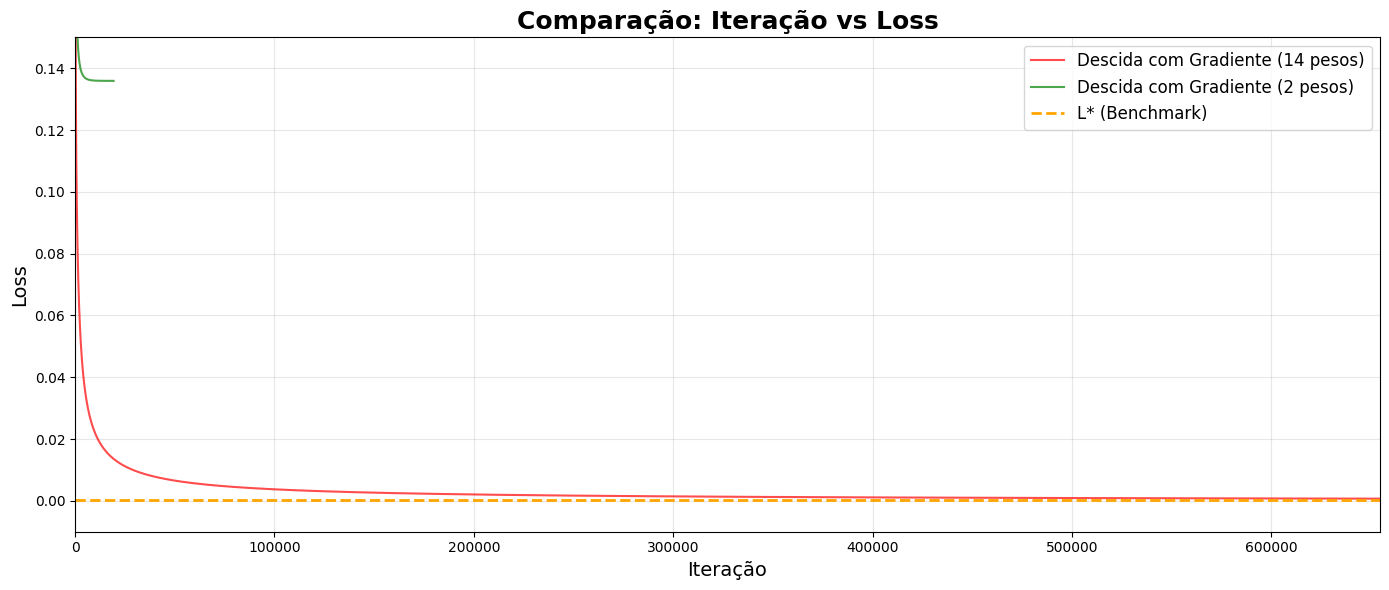

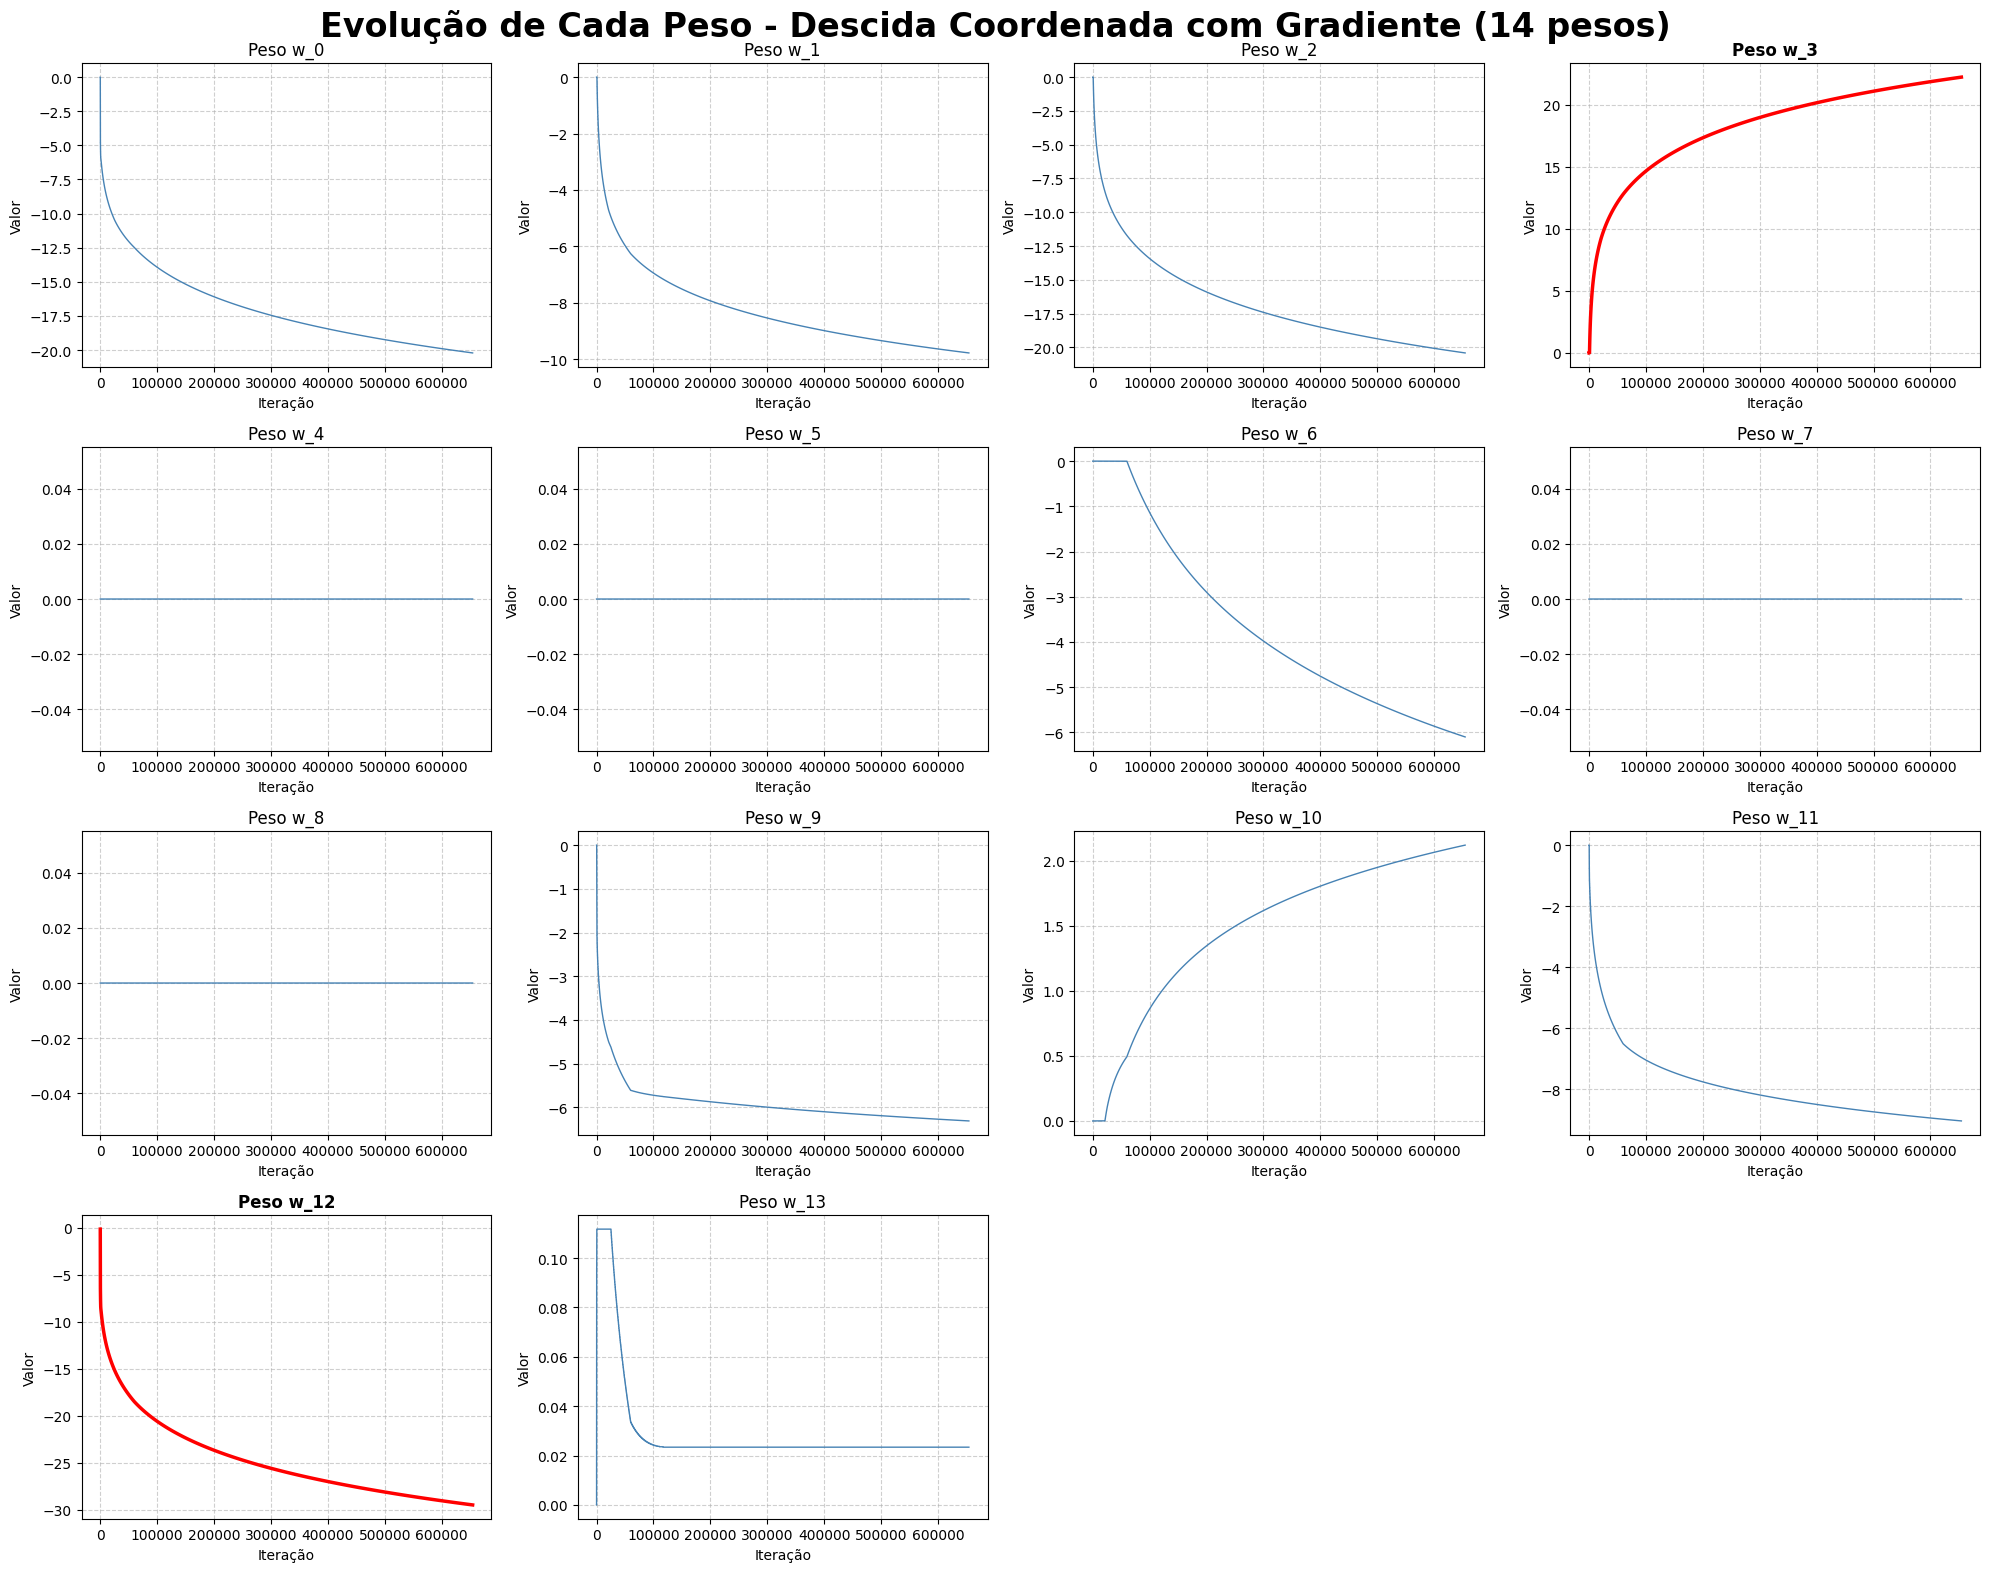


Calculando espaço de soluções


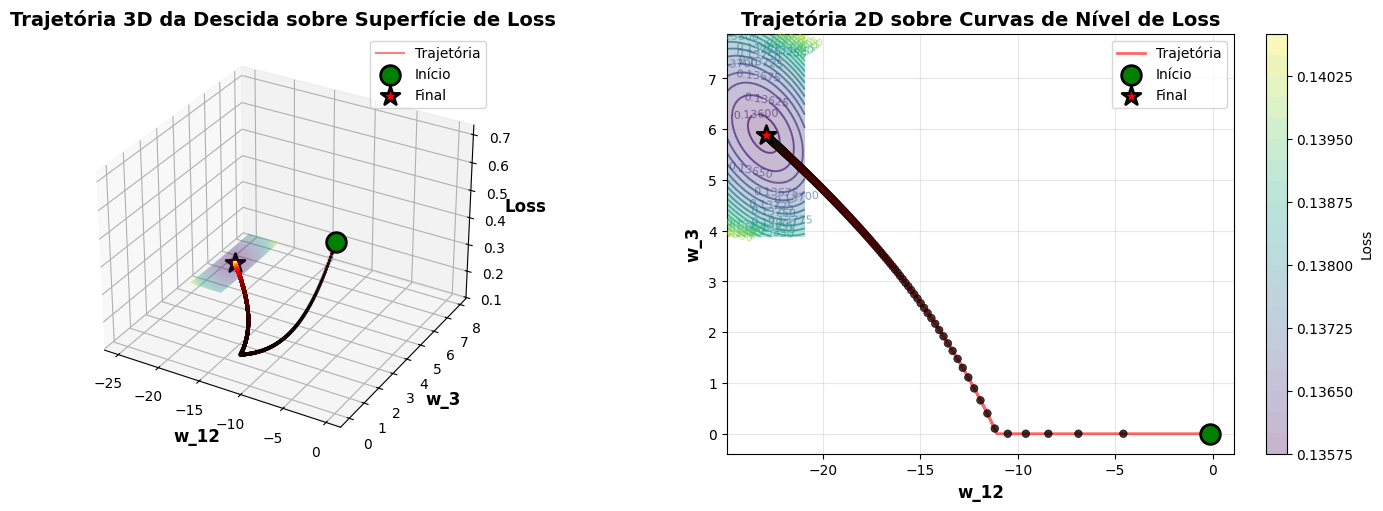

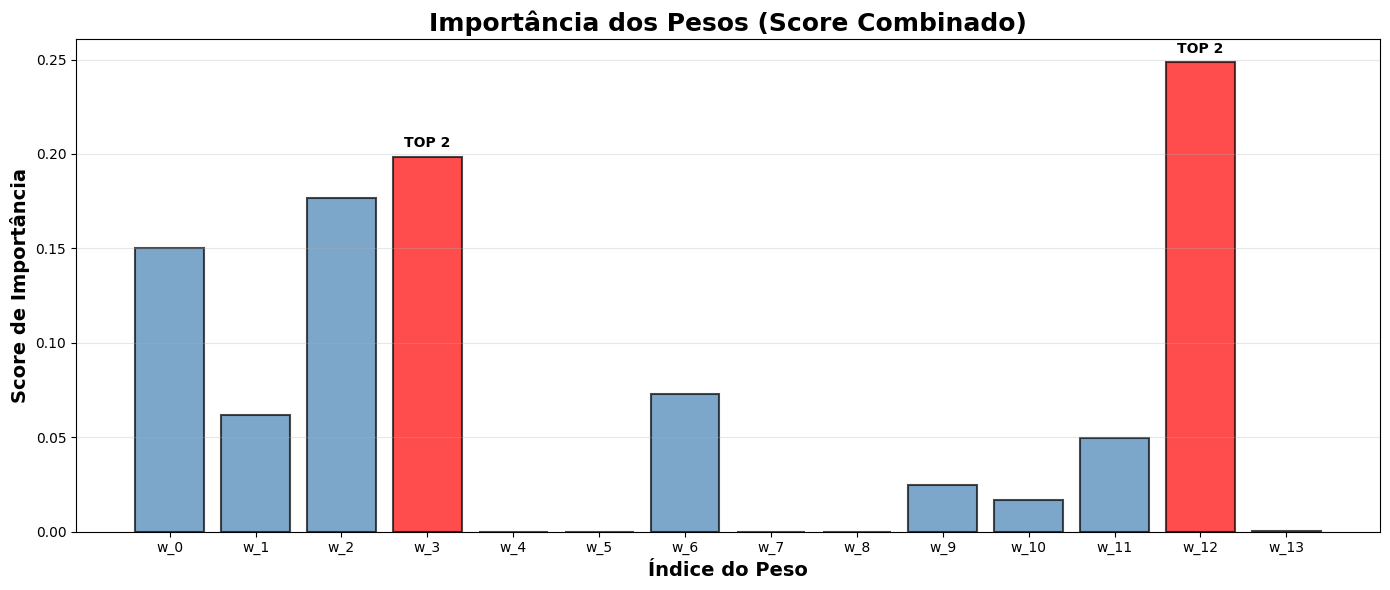


RESUMO FINAL

Pesos selecionados: w_12 e w_3

Performance com 14 pesos:
   - Loss: 0.0007019916
   - Tempo: 18.85s
   - Iterações: 654,425

Performance com 2 pesos:
   - Loss: 0.1359116900 (+19260.87% vs 14 pesos)
   - Tempo: 0.56s (97.02% mais rápido)
   - Iterações: 19,355

Conclusão:
   Usar apenas os 2 pesos mais importantes resulta em:
   - 97.0% de redução no tempo de treinamento
   - 19260.87% de degradação na loss
   - Redução de 97.0% nas iterações necessárias


In [ ]:
# Comparação de Loss ao longo das iterações
plt.figure(figsize=(14, 6))
plt.plot(loss_gradient, 'r-', label='Descida com Gradiente (14 pesos)', alpha=0.7, linewidth=1.5)
plt.plot(loss_2d, 'g-', label='Descida com Gradiente (2 pesos)', alpha=0.7, linewidth=1.5)
plt.axhline(y=L_star, color='orange', linestyle='--', linewidth=2, label='L* (Benchmark)')
plt.title('Comparação: Iteração vs Loss', fontsize=18, fontweight='bold')
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlim(0, max(total_iterations_14, total_iterations_2))
plt.ylim(-0.01, 0.15)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Evolução dos 14 pesos (Descida com Gradiente)
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Evolução de Cada Peso - Descida Coordenada com Gradiente (14 pesos)', 
             fontsize=24, fontweight='bold')
axes_flat = axes.flatten()

for i in range(num_features):
    ax = axes_flat[i]
    color = 'red' if i in top_2_indices else 'steelblue'
    linewidth = 2.5 if i in top_2_indices else 1.0
    ax.plot(weights_history_gradient[:, i], color=color, linewidth=linewidth)
    
    title = f'Peso w_{i}'
    ax.set_title(title, fontsize=12, fontweight='bold' if i in top_2_indices else 'normal')
    ax.set_xlabel('Iteração', fontsize=10)
    ax.set_ylabel('Valor', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)

axes_flat[14].axis('off')
axes_flat[15].axis('off')
plt.tight_layout()
plt.show()

# Criar grade de loss para visualizar espaço de soluções
print("\nCalculando espaço de soluções")

# Define grade de valores para w0 e w1
w0_range = np.linspace(w_2d[0, 0] - 2, w_2d[0, 0] + 2, 50)
w1_range = np.linspace(w_2d[1, 0] - 2, w_2d[1, 0] + 2, 50)
W0, W1 = np.meshgrid(w0_range, w1_range)

# Calcula loss para cada combinação de pesos
Z = np.zeros_like(W0)
for i in range(W0.shape[0]):
    for j in range(W0.shape[1]):
        w_temp = np.array([[W0[i, j]], [W1[i, j]]])
        Z[i, j] = compute_loss_for_weights(w_temp, X_reduced, y)

# Visualização 3D com superfície de loss
fig = plt.figure(figsize=(18, 12))

# Subplot 1: Vista 3D com superfície
ax1 = fig.add_subplot(221, projection='3d')
surface = ax1.plot_surface(W0, W1, Z, cmap='viridis', alpha=0.4, edgecolor='none')
iterations = np.arange(len(weights_history_2d))
scatter = ax1.scatter(weights_history_2d[:, 0], 
                      weights_history_2d[:, 1], 
                      loss_2d,
                      c=iterations, 
                      cmap='hot', 
                      s=3,
                      alpha=0.8)
ax1.plot(weights_history_2d[:, 0], 
         weights_history_2d[:, 1], 
         loss_2d, 
         'r-', 
         alpha=0.5, 
         linewidth=1.5,
         label='Trajetória')
ax1.scatter([weights_history_2d[0, 0]], 
            [weights_history_2d[0, 1]], 
            [loss_2d[0]], 
            c='green', 
            s=200, 
            marker='o', 
            label='Início',
            edgecolors='black',
            linewidths=2)
ax1.scatter([weights_history_2d[-1, 0]], 
            [weights_history_2d[-1, 1]], 
            [loss_2d[-1]], 
            c='red', 
            s=200, 
            marker='*', 
            label='Final',
            edgecolors='black',
            linewidths=2)
ax1.set_xlabel(f'w_{top_2_indices[0]}', fontsize=12, fontweight='bold')
ax1.set_ylabel(f'w_{top_2_indices[1]}', fontsize=12, fontweight='bold')
ax1.set_zlabel('Loss', fontsize=12, fontweight='bold')
ax1.set_title('Trajetória 3D da Descida sobre Superfície de Loss', fontsize=14, fontweight='bold')
ax1.legend()

# Projeção 2D com curvas de nível
ax2 = fig.add_subplot(222)
contour = ax2.contour(W0, W1, Z, levels=20, cmap='viridis', alpha=0.6)
ax2.clabel(contour, inline=True, fontsize=8)
contourf = ax2.contourf(W0, W1, Z, levels=20, cmap='viridis', alpha=0.3)

# Trajetória
trajectory = ax2.plot(weights_history_2d[:, 0], 
                      weights_history_2d[:, 1], 
                      'r-', 
                      alpha=0.6, 
                      linewidth=2,
                      label='Trajetória')
scatter2 = ax2.scatter(weights_history_2d[::50, 0], 
                       weights_history_2d[::50, 1], 
                       c=iterations[::50], 
                       cmap='hot', 
                       s=30, 
                       alpha=0.8,
                       edgecolors='black',
                       linewidths=0.5,
                       zorder=5)
ax2.scatter([weights_history_2d[0, 0]], 
            [weights_history_2d[0, 1]], 
            c='green', 
            s=200, 
            marker='o', 
            label='Início', 
            edgecolors='black', 
            linewidths=2,
            zorder=10)
ax2.scatter([weights_history_2d[-1, 0]], 
            [weights_history_2d[-1, 1]], 
            c='red', 
            s=200, 
            marker='*', 
            label='Final', 
            edgecolors='black', 
            linewidths=2,
            zorder=10)
ax2.set_xlabel(f'w_{top_2_indices[0]}', fontsize=12, fontweight='bold')
ax2.set_ylabel(f'w_{top_2_indices[1]}', fontsize=12, fontweight='bold')
ax2.set_title('Trajetória 2D sobre Curvas de Nível de Loss', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)
plt.colorbar(contourf, ax=ax2, label='Loss')

# Gráfico de barras: Importância dos pesos
plt.figure(figsize=(14, 6))
x_pos = np.arange(num_features)
colors = ['red' if i in top_2_indices else 'steelblue' for i in range(num_features)]
bars = plt.bar(x_pos, importance_score, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.xlabel('Índice do Peso', fontsize=14, fontweight='bold')
plt.ylabel('Score de Importância', fontsize=14, fontweight='bold')
plt.title('Importância dos Pesos (Score Combinado)', fontsize=18, fontweight='bold')
plt.xticks(x_pos, [f'w_{i}' for i in range(num_features)])
plt.grid(axis='y', alpha=0.3)

for i, (idx, score) in enumerate(zip(x_pos, importance_score)):
    if idx in top_2_indices:
        plt.text(i, score + 0.005, 'TOP 2', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("RESUMO FINAL")
print("="*70)
print(f"\nPesos selecionados: w_{top_2_indices[0]} e w_{top_2_indices[1]}")
print(f"\nPerformance com 14 pesos:")
print(f"   - Loss: {loss_gradient[-1]:.10f}")
print(f"   - Tempo: {time_gradient:.2f}s")
print(f"   - Iterações: {total_iterations_14:,}")
print(f"\nPerformance com 2 pesos:")
print(f"   - Loss: {loss_2d[-1]:.10f} ({degradation:+.2f}% vs 14 pesos)")
print(f"   - Tempo: {time_2d:.2f}s ({speedup_pct:.2f}% mais rápido)")
print(f"   - Iterações: {total_iterations_2:,}")
print(f"\nConclusão:")
print(f"   Usar apenas os 2 pesos mais importantes resulta em:")
print(f"   - {speedup_pct:.1f}% de redução no tempo de treinamento")
print(f"   - {degradation:.2f}% de degradação na loss")
print(f"   - Redução de {((total_iterations_14 - total_iterations_2)/total_iterations_14*100):.1f}% nas iterações necessárias")